# Representation of a Fiber Diffraction / Grazing Incidence pattern

## How to use pyFAI to display or reduce data from grazing-incidence/fiber scattering experiments

In [1]:
from pyFAI.test.utilstest import UtilsTest
from pyFAI.gui.jupyter import subplots, display, plot1d, plot2d
from pyFAI import load
from pyFAI.integrator.fiber import FiberIntegrator
from pyFAI.units import get_unit_fiber
from pyFAI.integrator.azimuthal import AzimuthalIntegrator
from pyFAI.io.ponifile import PoniFile
import fabio
import numpy
import time
import matplotlib.pyplot as plt
y6 = fabio.open(UtilsTest.getimage("Y6.edf")).data
air = fabio.open(UtilsTest.getimage("air.edf")).data
data = y6 - 0.03 * air
def update_style(ax):
    for img in ax.get_images():
        img.set_cmap("viridis")
        img.set_clim(10,500)
t0 = time.perf_counter()

### Since version 2025.01, pyFAI uses a specific Integrator for this case: FiberIntegrator
The FiberIntegrator can be created by three ways:
- Using `pyFAI.load` declaring the `pyFAI.integrator.fiber.FiberIntegrator` as `type_`
- Importing and instantiating directly a `pyFAI.integrator.fiber.FiberIntegrator`
- Promoting an `AzimuthalIntegrator` instance using `promote`

In [2]:
poni_filename = UtilsTest.getimage("LaB6_3.poni")

In [3]:
# 1st way
fi = load(filename=poni_filename, type_="pyFAI.integrator.fiber.FiberIntegrator")

# 2nd way
poni = PoniFile(data=poni_filename)
fi = FiberIntegrator(dist=poni.dist, poni1=poni.poni1, poni2=poni.poni2, 
                     wavelength=poni.wavelength, 
                     rot1=poni.rot1, rot2=poni.rot2, rot3=poni.rot3,
                     detector=poni.detector,
                    )

# 3rd way
ai = load(filename=poni_filename)
fi = ai.promote(type_="pyFAI.integrator.fiber.FiberIntegrator")

### FiberIntegrator has access to two main methods: 
- integrate2d_grazing_incidence == integrate2d_fiber
- integrate1d_grazing_incidence == integrate1d_fiber

#### integrate2d_grazing_incidence by default remaps a diffraction pattern into $q_{IP} (nm^{-1})$ vs $q_{OOP}(nm^{-1})$

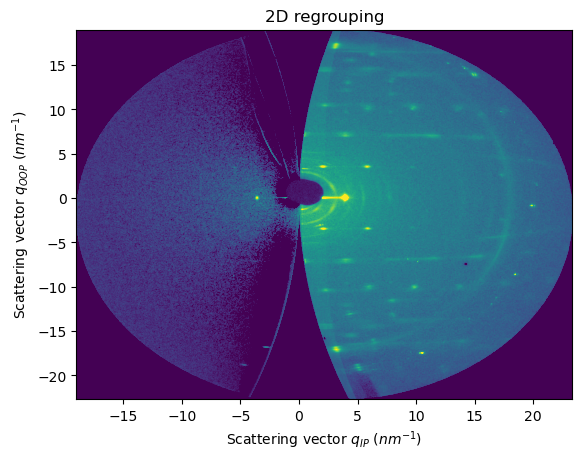

In [4]:
res2d_default = fi.integrate2d_grazing_incidence(data=data)
fig, ax = subplots()
plot2d(result=res2d_default, ax=ax)
update_style(ax=ax)
pass

#### The orientation of the axis can bet set with the parameter: `sample_orientation`
- There are 8 possible orientations (1 -> 8). Default value = 1

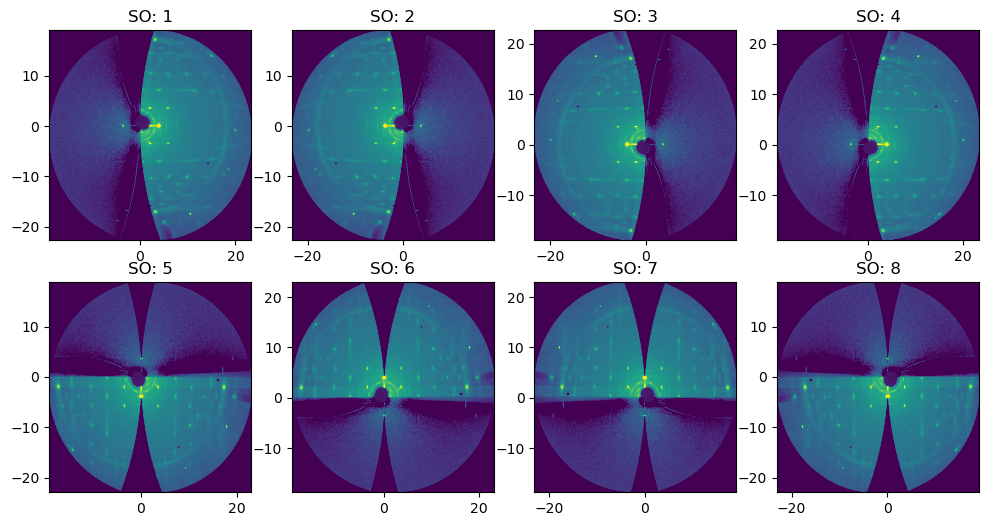

In [5]:
fig, axes = subplots(ncols=4, nrows=2, figsize=(12,6))
results_so = []
for sample_orientation in range(1,9):
    res = fi.integrate2d_grazing_incidence(data=data, sample_orientation=sample_orientation)
    ax = axes.ravel()[sample_orientation - 1]
    plot2d(result=res, ax=ax)
    update_style(ax=ax)
    ax.set_title(f"SO: {sample_orientation}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#### For this sample, due to a 90 degrees rotation of the detector, the correct `sample_orientation` is 6 or 7 (mirrored images)

### FiberIntegrator introduces three new parameters:
- sample_orientation (int) : default = 1
- incident_angle (η) (float) : default=0.0 (in radians). Tilt of the sample stage towards the beam (key parameter in grazing-incidence)
- tilt_angle (χ) (float) : default=0.0 (in radians). Horizon tilt of the sample stage (normally as close as 0.0 in grazing-incidence)

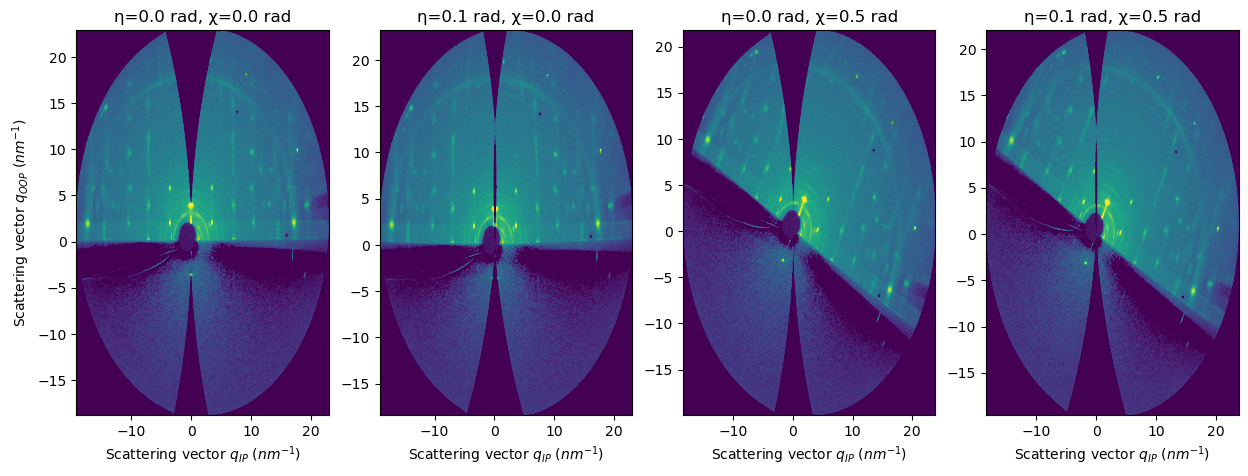

In [6]:
res_0 = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=0.0, tilt_angle=0.0)
res_1 = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=0.1, tilt_angle=0.0)
res_2 = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=0.0, tilt_angle=0.5)
res_3 = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=0.1, tilt_angle=0.5)
iangles = (0.0, 0.1, 0.0, 0.1)
tangles = (0.0, 0.0, 0.5, 0.5)
fig, axes = subplots(ncols=4, figsize=(15,5))
for iangle, tangle, ax, res in zip(iangles, tangles, axes.ravel(), [res_0, res_1, res_2, res_3]):
    plot2d(result=res, ax=ax)
    update_style(ax=ax)
    if ax != axes[0]:
        ax.set_ylabel("")
    ax.set_title(f"η={iangle} rad, χ={tangle} rad")

#### Effects:
- `incident_angle` changes the accessible region along the out-of-plane axis (just like in a reflectivity experiment)
- `tilt_angle` rotates the pattern around the direct beam point (q=0nm-1)

### q_IP and q_OOP are the default units for grazing-incidence/fiber data,  pyFAI provides methods for other `fiber` units
- qIP and qOOP in A-1
- The three components of q vector (in nm-1 and A-1)
- `integrate2d_exitangles` for horizontal and vertical exit angles in which the origin is the sample horizon (dependent of `incident_angle`)
- `integrate2d_polar` to represent the polar angles (as the arctan of qOOP / qIP) versus q modulus

In [7]:
# iangle = 0.1
# res_0 = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=iangle, unit_ip="qip_A^-1", unit_oop="qoop_A^-1")
# res_1 = fi.integrate2d_exitangles(data=data, sample_orientation=6, incident_angle=iangle)
# res_2 = fi.integrate2d_exitangles(data=data, sample_orientation=6, incident_angle=iangle, angle_degrees=False)
# res_3 = fi.integrate2d_polar(data=data, sample_orientation=6, incident_angle=iangle)
# res_4 = fi.integrate2d_polar(data=data, sample_orientation=6, incident_angle=iangle, polar_degrees=False, radial_unit="A^-1", rotate=True)

# fig, axes = subplots(ncols=5, figsize=(20,5))
# for ax, res in zip(axes.ravel(), [res_0, res_1, res_2, res_3, res_4]):
#     plot2d(result=res, ax=ax)
#     update_style(ax=ax)

## integrate1d_grazing_incidence
- This method slice regions of integrate2d_grazing_incidence maps (essentially, integrate1d using the new Fiber Units)
- Additional parameter to consider: `vertical_integration` : default = True

/gpfs/jazzy/data/scisoft/edgar/miniforge3/envs/edgar/lib/python3.12/site-packages/pyFAI/integrator/fiber.py:269: RuntimeWarning: invalid value encountered in divide
  intensity = sum_signal / sum_normalization


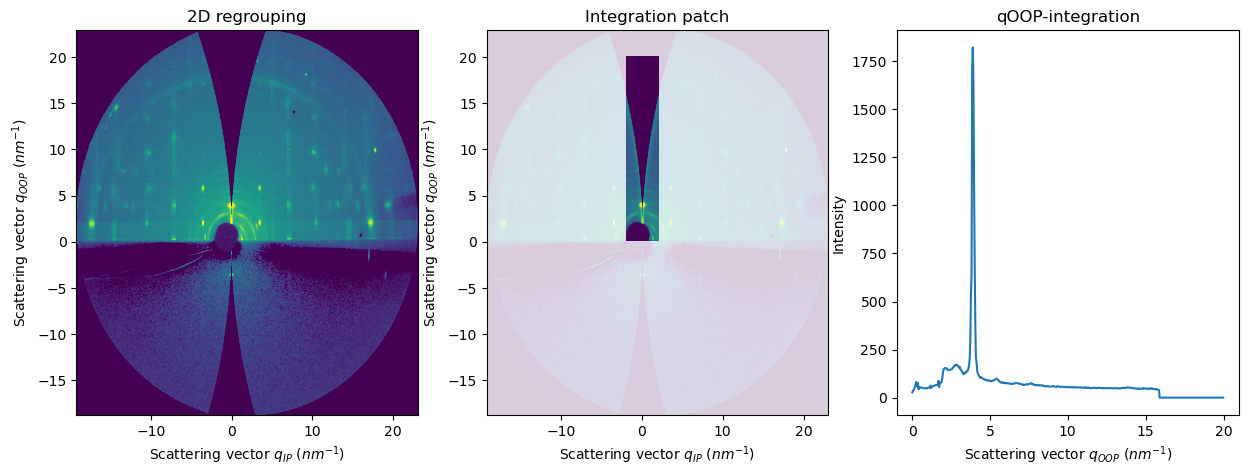

In [8]:
res2d = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12))
res2d_patch = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12),
                                               npt_ip=500, npt_oop=500,
                                               ip_range=(-2,2), oop_range=(0,20))

res1d_vertical = fi.integrate1d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12),
                                                  npt_ip=500, npt_oop=500,
                                                  ip_range=(-2,2), oop_range=(0,20))

fig, axes = subplots(ncols=3, figsize=(15,5))
plot2d(result=res2d, ax=axes[0])
plot2d(result=res2d_patch, ax=axes[1])
plot2d(result=res2d, ax=axes[1])
update_style(ax=axes[0])
update_style(ax=axes[1])
axes[1].get_images()[1].set_alpha(0.2)
plot1d(result=res1d_vertical, ax=axes[2])
axes[1].set_title("Integration patch")
axes[2].set_title("qOOP-integration")
pass

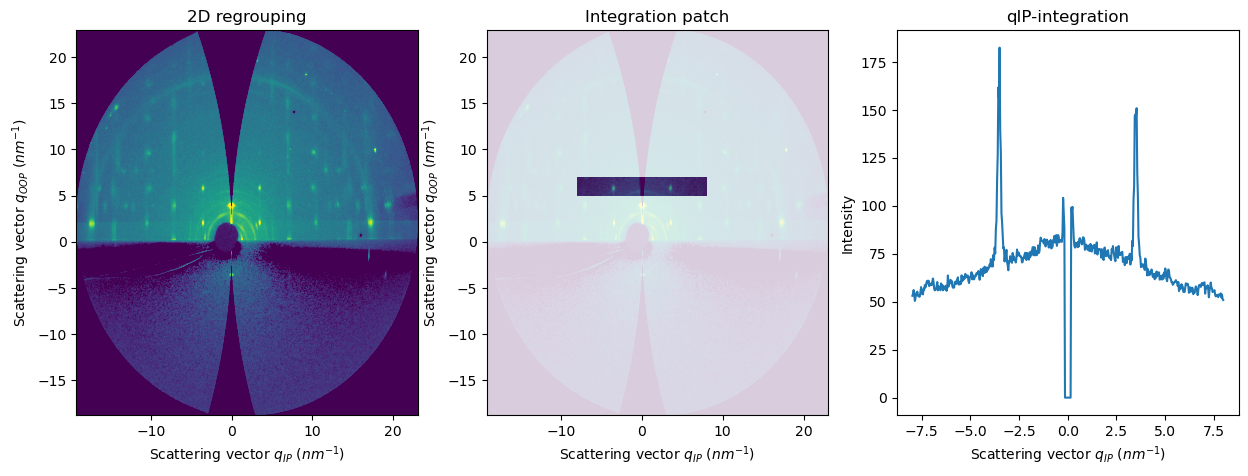

In [9]:
res2d = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12))
res2d_patch = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12),
                                               npt_ip=500, npt_oop=500,
                                               ip_range=(-8,8), oop_range=(5,7))

res1d_horizontal = fi.integrate1d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12),
                                                  npt_ip=500, npt_oop=500,
                                                  ip_range=(-8,8), oop_range=(5,7),
                                                    vertical_integration=False,
                                                   )

fig, axes = subplots(ncols=3, figsize=(15,5))
plot2d(result=res2d, ax=axes[0])
plot2d(result=res2d_patch, ax=axes[1])
plot2d(result=res2d, ax=axes[1])
update_style(ax=axes[0])
update_style(ax=axes[1])
axes[1].get_images()[1].set_alpha(0.2)
plot1d(result=res1d_horizontal, ax=axes[2])
axes[1].set_title("Integration patch")
axes[2].set_title("qIP-integration")
pass

### APIs for integrate1d using the exit angles and polar angles
- `integrate1d_polar`: intensity profile as a function of the polar angle (or inverse, integrate a polar angle sector as a function of q)
- `integrate1d_exitangles`: intensity profile along a specific exit angle (horizontal or vertical)

In [12]:
# res1d_polar_1 = fi.integrate1d_polar(data=data, 
#                                      npt_oop=1000, npt_ip=1000,
#                                      ip_range=[0,2], oop_range=[-2,2],
#                                      sample_orientation=sample_orientation, incident_angle=incident_angle)
# res1d_polar_2 = fi.integrate1d_polar(data=data, 
#                                      npt_oop=1000, npt_ip=1000, 
#                                      polar_degrees=True, radial_unit="A^-1", radial_integration=False, 
#                                      ip_range=[0,2], oop_range=[-2,2],
#                                      sample_orientation=sample_orientation, incident_angle=incident_angle)
# res1d_exitangle_1 = fi.integrate1d_exitangles(data=data, 
#                                               npt_oop=1000, npt_ip=1000,
#                                               ip_range=[-2,2], oop_range=[-20,20],
#                                               sample_orientation=sample_orientation, incident_angle=incident_angle)

# res1d_exitangle_2 = fi.integrate1d_exitangles(data=data, npt_oop=1000, npt_ip=1000, angle_degrees=True, 
#                                               ip_range=[-2,2], oop_range=[-20,20],
#                                               vertical_integration=True, 
#                                               sample_orientation=sample_orientation, incident_angle=incident_angle)


# fig, axes = subplots(ncols=4, figsize=(20,5))
# plot1d(result=res1d_polar_1, ax=axes[0])
# plot1d(result=res1d_polar_2, ax=axes[1])
# plot1d(result=res1d_exitangle_1, ax=axes[2])
# plot1d(result=res1d_exitangle_2, ax=axes[3])
# update_style(ax=axes[0])
# update_style(ax=axes[1])
# update_style(ax=axes[2])
# update_style(ax=axes[3])
# pass

### FiberIntegrator methods use non-pixel-splitting by default
- For AzimuthalIntegrator, integration methods use `bbox` pixel splitting scheme by default
- For integrate2d/integrate1d_grazing_incidence methods, the default pixel splitting scheme is set to `no`

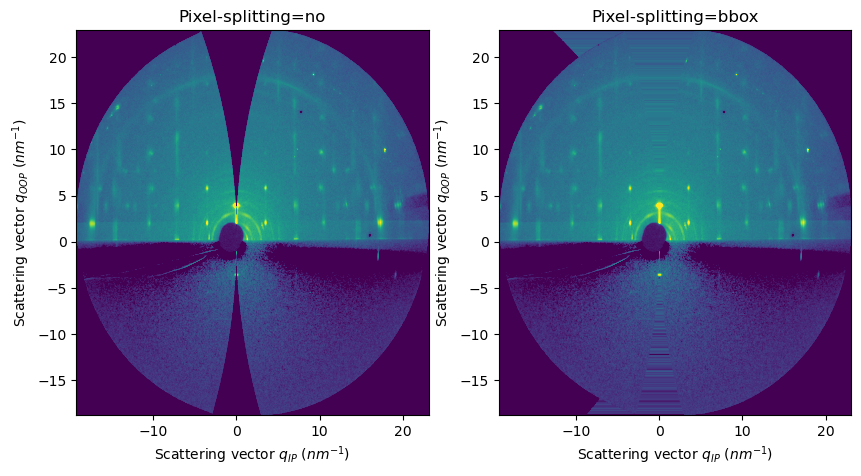

In [13]:
res2d_no = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12))
res2d_bbox = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12),
                                              method=("bbox", "csr", "cython")
                                             )


fig, axes = subplots(ncols=2, figsize=(10,5))
plot2d(result=res2d_no, ax=axes[0])
plot2d(result=res2d_bbox, ax=axes[1])
update_style(ax=axes[0])
update_style(ax=axes[1])
axes[0].set_title("Pixel-splitting=no")
axes[1].set_title("Pixel-splitting=bbox")
pass

#### **It's possible to switch the pixel splitting scheme, but the missing wedge will be filled with overlapping data**

### The filling of the gap will propagate to integrate1d

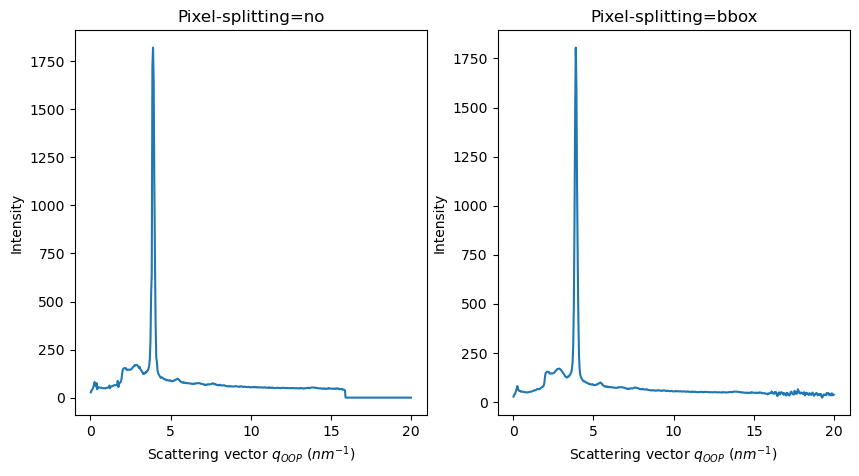

In [14]:
res1d_no = fi.integrate1d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12),
                                                  npt_ip=500, npt_oop=500,
                                                  ip_range=(-2,2), oop_range=(0,20))
res1d_bbox = fi.integrate1d_grazing_incidence(data=data, sample_orientation=6, incident_angle=numpy.deg2rad(0.12),
                                              npt_ip=500, npt_oop=500,
                                              ip_range=(-2,2), oop_range=(0,20),
                                              method=("bbox", "csr", "cython")
                                             )

fig, axes = subplots(ncols=2, figsize=(10,5))
plot1d(result=res1d_no, ax=axes[0])
plot1d(result=res1d_bbox, ax=axes[1])
update_style(ax=axes[0])
update_style(ax=axes[1])
axes[0].set_title("Pixel-splitting=no")
axes[1].set_title("Pixel-splitting=bbox")
pass

#### Above qoop=16nm-1, there is no data to integrate, if we use a pixel splitting scheme, this gap is filled (it's what pixel splitting does)

## Why the missing wedge?
The missing wedge appears when we represent the **qz component versus the in-plane q component.**

With a static geometry, we can only prove a **spherical shell** of the whole reciprocal space of the sample.

Every point of that shell is in "Bragg condition"; we call that shell the **Ewald sphere**.

What we see in the detector is the **projection of the Ewald sphere into the surface of the detector.**

We can represent that data in terms of the exit angles (horizontal and vertical)

But if we represent it with the units qoop-qip, we will see how a **sphere can only intersect a rod in 1 or 2 points.**
- If `incident_angle=0.0`, the only point of qoop in Bragg conditions is qoop=0
- If `incident_angle!=0.0`, there are two points in Bragg conditions: qoop=0 and qoop=incident_angle, which is the reflected beam.

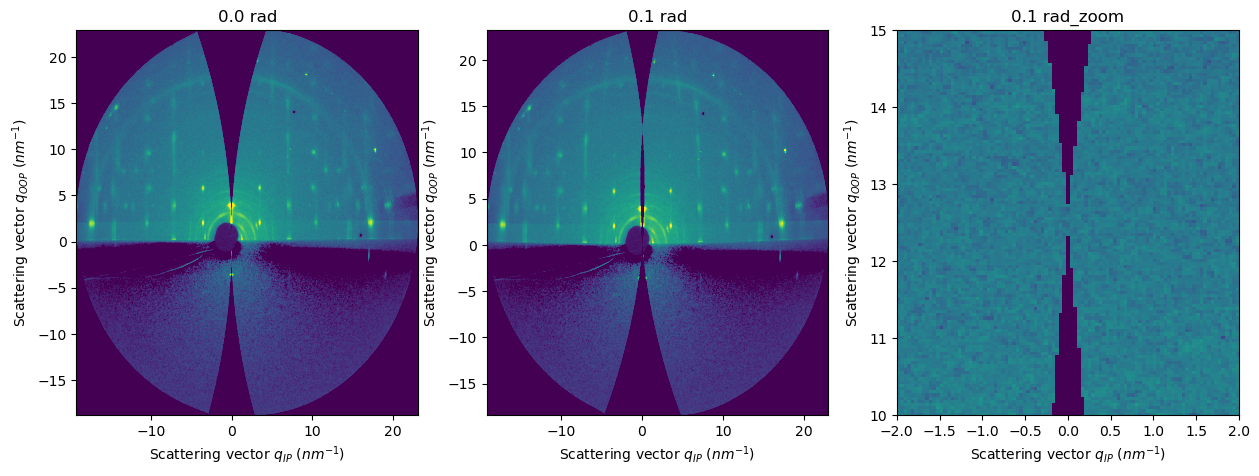

In [14]:
res2d_0 = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=0.0)
res2d_01rad = fi.integrate2d_grazing_incidence(data=data, sample_orientation=6, incident_angle=0.1)

fig, axes = subplots(ncols=3, figsize=(15,5))
plot2d(result=res2d_0, ax=axes[0])
plot2d(result=res2d_01rad, ax=axes[1])
plot2d(result=res2d_01rad, ax=axes[2])
update_style(ax=axes[0])
update_style(ax=axes[1])
update_style(ax=axes[2])
axes[2].set_xlim(-2,2)
axes[2].set_ylim(10,15)
axes[0].set_title("0.0 rad")
axes[1].set_title("0.1 rad")
axes[2].set_title("0.1 rad_zoom")
pass

In [15]:
incident_angle = 0.1
q_bragg = 4 * numpy.pi / fi.wavelength * numpy.sin(2 * incident_angle / 2) / 1e9
print(f"Along qoop, we only prove 0.0nm^-1 and {q_bragg:.2f} nm^-1")

Along qoop, we only prove 0.0nm^-1 and 12.55 nm^-1


#### The missing wedge appears because we represent the surface of a sphere (Ewald) as a function of one of the 3D axis (qOOP = qVertical)
The same way, we get a missing wedge in the horizontal axis if we plot data as a function of (Qxz - Qy)

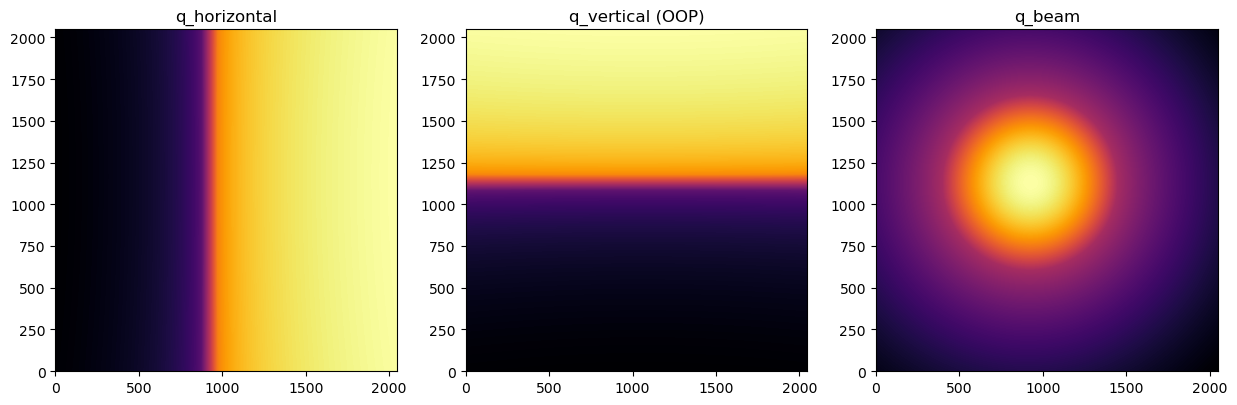

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
arr_qx = fi.array_from_unit(unit=get_unit_fiber("qxgi_nm^-1"))
arr_qy = fi.array_from_unit(unit=get_unit_fiber("qygi_nm^-1"))
arr_qz = fi.array_from_unit(unit=get_unit_fiber("qzgi_nm^-1"))
display(arr_qx, ax=axes[0], label="q_horizontal")
display(arr_qy, ax=axes[1], label="q_vertical (OOP)")
display(arr_qz, ax=axes[2], label="q_beam")
pass

/tmp/ipykernel_641730/1134296278.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(arr_qxz, arr_qy, data, vmin=0, vmax=500)
/tmp/ipykernel_641730/1134296278.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(arr_qx, arr_qyz, data, vmin=0, vmax=500)


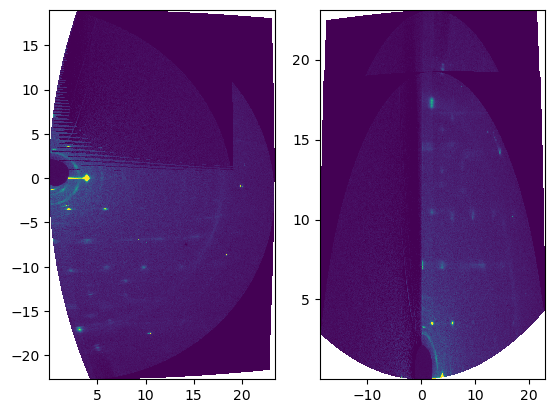

In [17]:
fig, ax = plt.subplots(ncols=2)
arr_qx = fi.array_from_unit(unit=get_unit_fiber("qxgi_nm^-1"))
arr_qy = fi.array_from_unit(unit=get_unit_fiber("qygi_nm^-1"))
arr_qz = fi.array_from_unit(unit=get_unit_fiber("qzgi_nm^-1"))
arr_qxy = numpy.sqrt(arr_qx ** 2 + arr_qy ** 2)
arr_qxz = numpy.sqrt(arr_qx ** 2 + arr_qz ** 2)
arr_qyz = numpy.sqrt(arr_qy ** 2 + arr_qz ** 2)
ax[0].pcolormesh(arr_qxz, arr_qy, data, vmin=0, vmax=500)
ax[1].pcolormesh(arr_qx, arr_qyz, data, vmin=0, vmax=500)
pass

In [18]:
print(f"Total run-time: {time.perf_counter()-t0:.3f}s")

Total run-time: 72.904s


## Conclusions

- PyFAI provides a simple API to represent a data array as a function of in-plane and out-of-plane components of vector q.
- This is a standard way to display GIWAXS/GISAXS or fiber diffraction patterns.
- New parameters to take into account:
    - `sample_orientation`
    - `incident_angle`
    - `tilt_angle`
- Other possible new coordinates:
    - `exit_angle_vert` vs `exit_angle_horz`
    - `polar_angle` vs `qtot`